# Recommender systems
In this notebook we will use a **collaborative filtering** algorithm and apply it on a movie rating dataset to recommend movies to users. Ratings are from 1 to 5. The dataset has $n_u = 943$ users and $n_m = 1682$ movies.

## Movie rating dataset
The dataset *ex8_movies.mat* contains the variables $Y$ and $R$. $Y$ is a matrix of size $n_m \times n_u$ which stores the ratings $y^{(i,j)}$ from 1 to 5. $R$ is a binary-valued indicator matrix where $R(i,j) = 1$ if user $j$ gave a rating to movie $i$ and $R(i,j) = 0$ otherwise. Let's compute the average rating for the first movie (Toy Story). We can also visualize the rating matrix as a whole.

In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
#load movie ratings
data = loadmat("ex8_movies.mat")
Y = data['Y']
n_movies, n_users = Y.shape
R = data['R']

#load movie names
movies = np.empty((Y.shape[0]), dtype='object')
with open("movie_ids.txt") as movie_ids:
    lines = movie_ids.readlines()
    for index, line in enumerate(lines):
        movies[index] = line.strip('\n').split(sep=' ', maxsplit=1)[1]

In [4]:
#print average rating for first movie
print("Average rating {0}: {1:.1f}".format(movies[0], np.mean(Y[0, :][R[0, :] == 1])))

Average rating Toy Story (1995): 3.9


Text(0.5,1,'Ratings of movies by users')

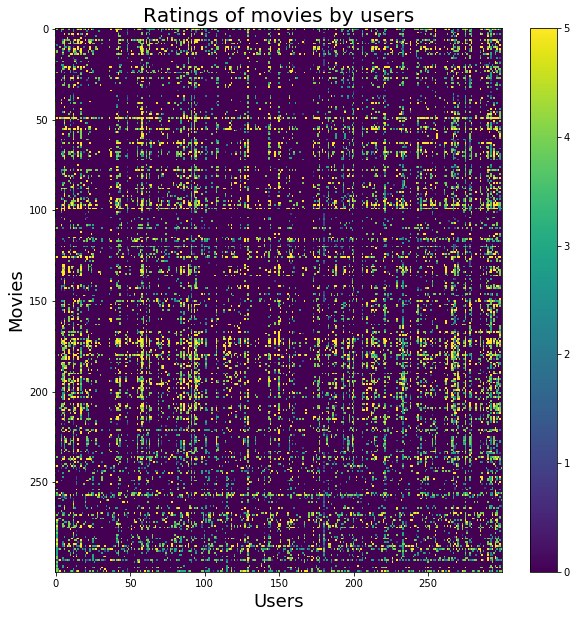

In [5]:
#show the rating data as a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(Y[:300, :300], aspect='auto')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('Users', fontsize=18)
ax.set_ylabel('Movies', fontsize=18)
ax.set_title('Ratings of movies by users', fontsize=20)

We will also be working with matrices $X$ and $Theta$. The $i$-the row of $X$ corresponds to the feature vector $x^{(i)}$ for the $i$-th movie and the $j$-th row of $Theta$ corresponds to one parameter vector $\theta^{(j)}$, for the $j$-th user. In this exercise we will use smaller versions of $X$ and $Theta$ so $x^{(i)} \in R^{10}$ and $\theta^{(j)} \in R^{10}$. Correspondingly, $X$ is a $n_m \times 10$ matrix and $Theta$ is a $n_u \times 10$ matrix.


In [6]:
movie_params = loadmat("ex8_movieParams.mat")
X = movie_params['X']
Theta = movie_params['Theta']
n_features = int(movie_params['num_features'])
num_features = n_features

#fold X and Theta in a single 1D array
params = np.concatenate((X.ravel(), Theta.ravel()))

## Collaborative filtering learning algorithm
First, we will implement the cost function. The collaborative filtering learning algorithm considers a set of $n$-dimensional prameter vectors $x^{(1)}, ..., x^{(n_m)}$ and $\theta^{(1)}, ..., \theta^{(n_u)}$. The model predicts the rating for movie $i$ by user $j$ as $y^{(i,j} = (\theta^{(j)})^T x^{(i)}$. Given a dataset that consists of ratings produced by users on movies, you wish to learn the parameter matrices $X$ and $Theta$ that produce the best fit, as measured by the squared error.

In [7]:
#cost function
#minimization fails with scipy.minimize
def cofi_cost(params, Y, R, lamb, n_features):
    
    n_movies, n_users = Y.shape
    
    #unfold back parameters to X and Theta
    X = params[:n_movies * n_features].reshape((n_movies, n_features))
    Theta = params[n_movies * n_features:].reshape((n_users, n_features))
    
    #calculate unregularized cost and gradient
    J_unreg = np.sum(np.sum((np.dot(X, Theta.T) * R - Y) ** 2)) / 2
    X_grad_unreg = np.dot((np.dot(X, Theta.T) * R - Y), Theta)
    Theta_grad_unreg = np.dot((np.dot(X, Theta.T) * R - Y).T, X)
    
    #calculate regularized cost and gradient
    J = J_unreg + lamb / 2 * np.sum(np.sum(Theta ** 2)) + lamb / 2 * np.sum(np.sum(X ** 2))
    X_grad = X_grad_unreg + lamb * X
    Theta_grad = Theta_grad_unreg + lamb * Theta
    
    return J, X_grad, Theta_grad

#this cost function is minimized by scipy.minimize
def cofi_cost2(params, Y, R, lmda, n_features):
    
    num_movies, num_users = Y.shape
    
    X = params[:num_movies*num_features].reshape( (num_movies, num_features) )
    Theta = params[num_movies*num_features:].reshape( (num_users, num_features) )
   
    X_grad = np.zeros( (X.shape) )
    Theta_grad = np.zeros( (Theta.shape) )
    
    J = np.sum(np.square( np.multiply( X.dot(Theta.T) - Y, R ) )) / 2
    X_grad = np.multiply( X.dot(Theta.T) - Y, R ).dot(Theta) + lmda * X
    Theta_grad = np.multiply( X.dot(Theta.T) - Y, R ).T.dot(X) + lmda * Theta
    
    reg_x = (lmda/2) * np.sum( np.square(X) ) 
    reg_theta = (lmda/2) * np.sum( np.square(Theta) ) 
    
    return ( J + reg_x + reg_theta, np.concatenate( ( X_grad.ravel(), Theta_grad.ravel() ) ) )

In [8]:
#normalize Y
def norm_ratings2(Y, R):
    m, n = Y.shape
    Y_mean = np.zeros((m, 1))
    Y_norm = np.zeros((m, n))
    for i in range(m):
        index = np.where(Y[i] ==  1)
        Y_mean[i] = np.mean(Y[i][index])
        Y_norm[i][index] = Y[i][index] - Y_mean[i]
        
    return Y_norm, Y_mean

def norm_ratings(Y, R):
    Y_mean = np.sum(Y, axis=1) / np.sum(R, axis=1)
    Y_mean = Y_mean.reshape((Y_mean.shape[0], 1))
    
    return Y - Y_mean, Y_mean

Y_norm, Y_mean = norm_ratings(Y, R)

In [9]:
#train the recommendation algorithm
lmda = 10
X_init = np.random.randn(n_movies, n_features)
Theta_init = np.random.randn(n_users, n_features)
initial_params = np.concatenate((X_init.ravel(), Theta_init.ravel()))

theta = minimize(fun=cofi_cost2, x0=initial_params, 
                 args=(Y_norm, R, lmda, n_features),
                 method='CG', jac=True, options={'maxiter':100})

In [29]:
#make predictions

#unfold theta into X and Theta matrices
X = theta.x[:n_movies * n_features].reshape((n_movies, n_features))
Theta = theta.x[n_movies * n_features:].reshape((n_users, n_features))

#calculate predictions for 1st user
p = np.dot(X, Theta.T)
mypredict = p[:, 1] + Y_mean.flatten()

#get index of sorted predictions from highest to lowest
index_pred = np.argsort(mypredict)[::-1]

#get ratings for sorted predictions
rating_pred = np.sort(mypredict)[::-1]

In [32]:
#show movies with best predicted ratings
print('Top recommendations for user #1')
for i in range(10):
    print('Predicted rating {0:.1f} for movie {1}.'.format(rating_pred[i], movies[index_pred[i]]))

Top recommendations for user #1
Predicted rating 5.0 for movie Someone Else's America (1995).
Predicted rating 5.0 for movie Santa with Muscles (1996).
Predicted rating 5.0 for movie Aiqing wansui (1994).
Predicted rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating 5.0 for movie Saint of Fort Washington, The (1993).
Predicted rating 5.0 for movie Great Day in Harlem, A (1994).
Predicted rating 5.0 for movie Prefontaine (1997).
Predicted rating 5.0 for movie They Made Me a Criminal (1939).
Predicted rating 5.0 for movie Star Kid (1997).
